## 데이터 내려받기 테스트

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"spa8453","key":"fdddd62cb348e218791779c783209cd0"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 50.4MB/s]


In [4]:
!unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# 간단한 합성곱 만들기
- 합성곱 층과 MaxPooling 층을 연달아서 쌓아 올림

In [5]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(28, 28, 1)) # 입력층 만듬

# 합성곱 층, filters=32 깊이
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs) # 함수형 API
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x) #
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)

# 출력층
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

## 모델 요약

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

## MNIST 이미지 합성곱 훈련
- 2장의 연결 네트워크는 97.8%

In [7]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/5
938/938 [==============================] - 15s 4ms/step - loss: 0.1584 - accuracy: 0.9503
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0443 - accuracy: 0.9861
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0307 - accuracy: 0.9911
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0237 - accuracy: 0.9928
Epoch 5/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0176 - accuracy: 0.9945


In [8]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('테스트 정확도 : ', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.0246 - accuracy: 0.9930
테스트 정확도 :  0.9929999709129333


## 최대 풀링 연산
- p292
- 최대 풀링 층이 빠진 잘못된 구조의 합성곱
  - 가장 큰 문제점 : 이미지 압축이 안됨
- CNN 구조 파악에 도움 : http://alexlenail.me/NN-SVG/index.html

In [9]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)
model_no_max_pool.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 61952)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                619530    
                                                                 
Total params: 712,202
Trainable params: 712,202
Non-trainab

# 개와 고양이로 이루어진 소규모 데이터셋에서 밑바닥부터 컨브넷 훈련

In [10]:
!kaggle competitions download -c dogs-vs-cats

 99% 807M/812M [00:07<00:00, 46.1MB/s]
100% 812M/812M [00:07<00:00, 112MB/s] 


In [11]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

In [12]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

## 모델 만들기

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3)) # 180 * 180 크기의 RGB 이미지를 기대한다.
x = layers.Rescaling(1./255)(inputs) # 입력을 255로 나누어 [0, 1]범위로 스케일을 조정한다.
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [14]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## 데이터 전처리
- p301

In [16]:
from tensorflow.keras.utils import image_dataset_from_directory

new_base_dir = pathlib.Path('cats_vs_dogs_small')

train_dataset = image_dataset_from_directory(
    new_base_dir / 'train',
    image_size=(180, 180),
    batch_size = 32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / 'validation',
    image_size=(180, 180),
    batch_size = 32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / 'test',
    image_size=(180, 180),
    batch_size = 32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### 텐서플로 Dataset 객체 이해하기
- 샘플 데이터 1000개 만들기

In [17]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

- 하나의 샘플 확인하기

In [18]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


- 데이터 배치

In [19]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


- 원소 크기를 (16, ) --> (4, 4)

In [20]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (2, 8)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(2, 8)
(2, 8)
(2, 8)


## Dataset이 반환하는 데이터 및 레이블 크기 확인

In [21]:
for data_batch, labels_batch in train_dataset:
  print('데이터 배치 크기:', data_batch.shape)
  print('레이블 배치 크기:', labels_batch.shape)
  break

데이터 배치 크기: (32, 180, 180, 3)
레이블 배치 크기: (32,)


## 모델 훈련하기

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'convnet_from_scratch.keras',
        save_best_only=True, # 1epoch vs 2 epoch
        monitor='val_loss'
    )
]

history = model.fit(
    train_dataset,
    epochs = 30,
    validation_data = validation_dataset,
    callbacks = callbacks
)

Epoch 1/30
63/63 [==============================] - 9s 91ms/step - loss: 0.7076 - accuracy: 0.4910 - val_loss: 0.6924 - val_accuracy: 0.5060
Epoch 2/30
63/63 [==============================] - 5s 65ms/step - loss: 0.7145 - accuracy: 0.5175 - val_loss: 0.6851 - val_accuracy: 0.5530
Epoch 3/30
63/63 [==============================] - 4s 64ms/step - loss: 0.6875 - accuracy: 0.5635 - val_loss: 0.6799 - val_accuracy: 0.5210
Epoch 4/30
63/63 [==============================] - 5s 79ms/step - loss: 0.6860 - accuracy: 0.5710 - val_loss: 0.6832 - val_accuracy: 0.5250
Epoch 5/30
63/63 [==============================] - 4s 64ms/step - loss: 0.6502 - accuracy: 0.6280 - val_loss: 0.6123 - val_accuracy: 0.6720
Epoch 6/30
63/63 [==============================] - 4s 65ms/step - loss: 0.6116 - accuracy: 0.6815 - val_loss: 0.5897 - val_accuracy: 0.6830
Epoch 7/30
63/63 [==============================] - 5s 82ms/step - loss: 0.5914 - accuracy: 0.6915 - val_loss: 0.6225 - val_accuracy: 0.6540
Epoch 8/30
63

In [23]:
import matplotlib.pyplot as plt

def vis(history):
  history_dict = history.history
  loss_values = history_dict["loss"]
  val_loss_values = history_dict["val_loss"]
  acc = history_dict["accuracy"]
  val_acc = history_dict["val_accuracy"]
  epochs = range(1, len(loss_values) + 1)

  figure, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 8))

  ax[0].plot(epochs, loss_values, "bo", label="Training loss")
  ax[0].plot(epochs, val_loss_values, "b", label="Validation loss")
  ax[0].set_title("Training and validation loss")
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Loss")
  ax[0].legend()

  ax[1].plot(epochs, acc, "bo", label="Training acc")
  ax[1].plot(epochs, val_acc, "b", label="Validation acc")
  ax[1].set_title("Training and validation accuracy")
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Accuracy")
  ax[1].legend()

  plt.show()

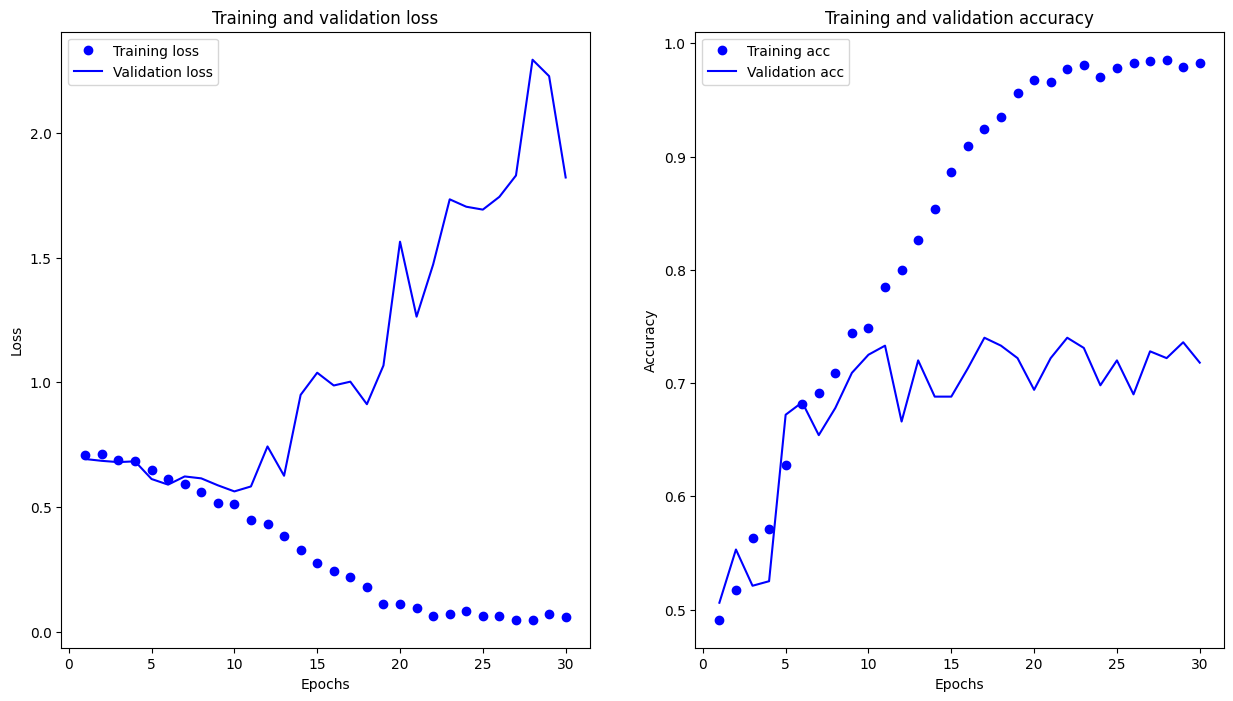

In [24]:
vis(history)

## 테스트 모델에서 모델 평가

In [25]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 4s 53ms/step - loss: 0.5896 - accuracy: 0.6980
테스트 정확도: 0.698


## 데이터 증식 사용

In [26]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

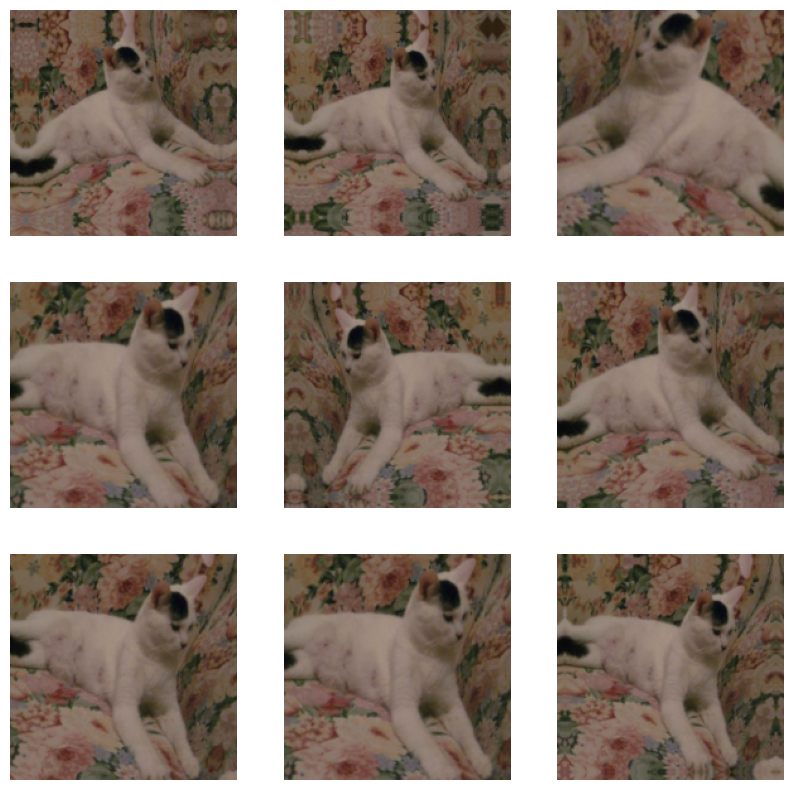

In [30]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [31]:
inputs = keras.Input(shape=(180, 180, 3)) # 입력층
x = data_augmentation(inputs) # 데이터 증식 단계 통과
x = layers.Rescaling(1./255)(x) # 이미지 [0, 1]

# 은닉층
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.5)(x) # 드롭아웃을 적용하면 과대적합이 덜 일어난다.

# 출력층
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [32]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

## 모델 훈련하기

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'convnet_from_scratch_with_augmentation.keras',
        save_best_only=True, # 1epoch vs 2 epoch
        monitor='val_loss'
    )
]

history = model.fit(
    train_dataset,
    epochs = 100,
    validation_data = validation_dataset,
    callbacks = callbacks
)

## 테스트 세트에서 모델 정확도 확인

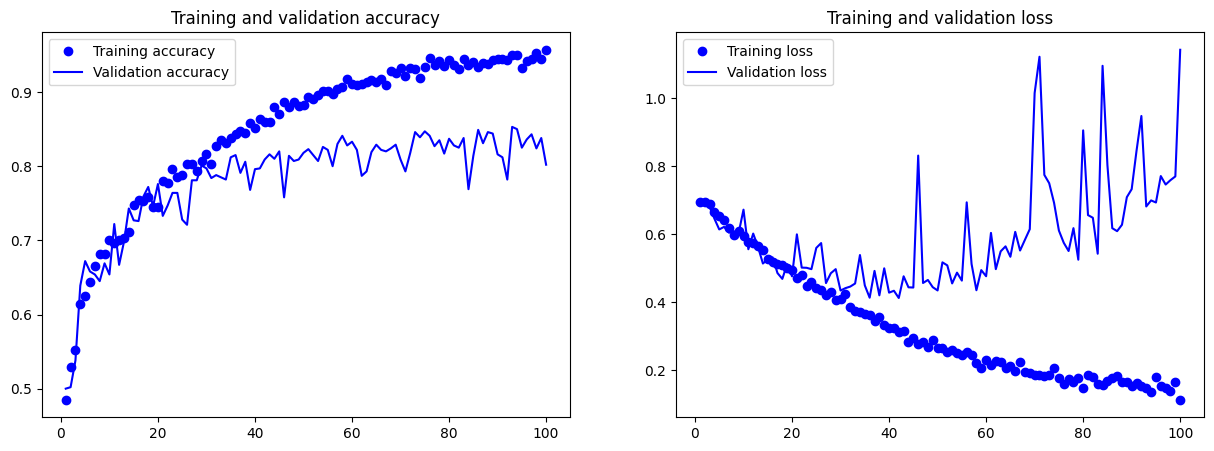

In [ ]:
check_train_val_plot(history)

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras") # 저장된 모델 불러오기
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 4s 46ms/step - loss: 0.4480 - accuracy: 0.8175
테스트 정확도: 0.817


## 머신러닝 프로젝트 vs 딥러닝 프로젝트
- 머신러닝 프로젝트의 핵심은 정확도 + 변수 추출 과정 설명 중요
  - 분석가 지망생들이 많이 함
- 딥러닝 프로젝트의 핵심은 정확도 + 어떤 모델 썼느냐 + 모델에 대한 설명(영어 논문 또는 한글로 번역한 유튜브 공부)
  - 컴공 출신들이 많이 함

# 사전 훈련된 모델 활용
- pretrained model

## 사전 훈련된 모델
- 일반 정확도 : 72.3
- 데이터 증식 정확도 : 82.8
- 사전 훈련된 모델 : 97.5
- 모델 미세 조정하기 : 98.5
- 결론 : 딥러닝 프로젝트 진행 시,
  - 주요 키워드 --> 사전 훈련된 모델 & 모델 미세 조정하기 --> chat gpt에 사전 훈련된 모델 샘플 코드 받아서 쓰기

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

- p312
- 훈련된 합성곱 기반 층 (동결)
  - vgg16에서 정의된 구조를 그대로 이어받아서 사용하겠다.
- ImageNet 데이터셋에서 훈련했다! ==> 대용량 & 다양한 이미지를 학습했다.

In [ ]:
from tensorflow.python.util.traceback_utils import include_frame
# 2014년에 제안된 모델
conv_base = keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top = False,
    input_shape = (180, 180, 3)
)

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

### 특성 추출
- 데이터 증식을 사용하지 않는 특성 추출


In [ ]:
# predict() 메서드 호출 넘파이 배열로 특성을 추출

def get_features_and_labels(dataset):
    all_features = [] # 특성
    all_labels = [] # 각 특성에 맞는 label
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images) # 고양이 1, 개 0
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

- 데이터 불러오기

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 35ms/step


In [ ]:
train_features.shape, train_labels.shape

((2000, 5, 5, 512), (2000,))

In [ ]:
val_features.shape, val_labels.shape

((1000, 5, 5, 512), (1000,))

In [ ]:
test_features.shape, test_labels.shape

((2000, 5, 5, 512), (2000,))

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg")
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)

1/1 [==============================] - 0s 231ms/step


## 출력층 정의하고 재훈련

In [ ]:
# 상단에 vgg16이 있고 그걸 참고하면 여기 출력층이 5, 5, 512
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs) # Dense 특성 주입하기 전에 Flatten층을 사용합니다.
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 11ms/step - loss: 18.9229 - accuracy: 0.9185 - val_loss: 4.1085 - val_accuracy: 0.9660
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 3.3479 - accuracy: 0.9770 - val_loss: 3.0416 - val_accuracy: 0.9790
Epoch 3/20
63/63 [==============================] - 0s 5ms/step - loss: 2.3154 - accuracy: 0.9820 - val_loss: 4.3708 - val_accuracy: 0.9720
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 0.7072 - accuracy: 0.9960 - val_loss: 4.0771 - val_accuracy: 0.9720
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 1.2333 - accuracy: 0.9865 - val_loss: 5.5747 - val_accuracy: 0.9720
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 0.5336 - accuracy: 0.9940 - val_loss: 4.7309 - val_accuracy: 0.9740
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 0.5965 - accuracy: 0.9960 - val_loss: 6.5225 - val_accuracy: 0.9660
Epoch 8/20
63/63 [

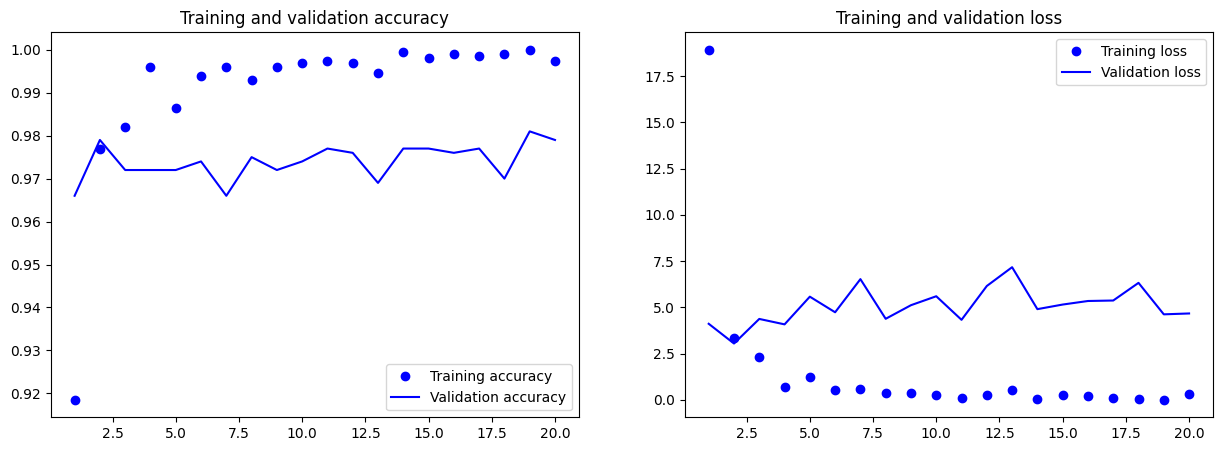

In [ ]:
check_train_val_plot(history)

# 사전 훈련된 모델 활용2

In [ ]:
from tensorflow.python.util.traceback_utils import include_frame

conv_base = tf.keras.applications.EfficientNetV2M(
    weights='imagenet',
    include_top = False,
    input_shape = (180, 180, 3)
)

## 특성 추출

In [ ]:
# predict() 메서드 호출 넘파이 배열로 특성을 추출

def get_features_and_labels(dataset):
    all_features = [] # 특성
    all_labels = [] # 각 특성에 맞는 label
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images) # 고양이 1, 개 0
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

- 데이터 불러오기

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 51ms/step


In [ ]:
train_features.shape, train_labels.shape
val_features.shape, val_labels.shape
test_features.shape, test_labels.shape

((2000, 6, 6, 1280), (2000,))

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.preprocessing import image
import numpy as np

# Load EfficientNetV2M model
model = EfficientNetV2M(weights='imagenet', include_top=False)

# Replace 'cat.jpg' and the URL with your image file information
img_path = tf.keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg")
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)


1/1 [==============================] - 5s 5s/step


## 출력층 정의하고 재훈련

In [ ]:
# 상단에 EfficientNetV2M이 있고 그걸 참고하면 여기 출력층이 6, 6, 1280
inputs = keras.Input(shape=(6, 6, 1280))
x = layers.Flatten()(inputs) # Dense 특성 주입하기 전에 Flatten층을 사용합니다.
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 3s 29ms/step - loss: 4.0804 - accuracy: 0.8920 - val_loss: 3.4077 - val_accuracy: 0.9120
Epoch 2/20
63/63 [==============================] - 5s 83ms/step - loss: 1.7070 - accuracy: 0.9460 - val_loss: 2.0313 - val_accuracy: 0.9370
Epoch 3/20
63/63 [==============================] - 1s 11ms/step - loss: 0.9831 - accuracy: 0.9695 - val_loss: 3.0046 - val_accuracy: 0.9210
Epoch 4/20
63/63 [==============================] - 1s 14ms/step - loss: 0.5945 - accuracy: 0.9740 - val_loss: 3.4792 - val_accuracy: 0.9190
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 0.5887 - accuracy: 0.9800 - val_loss: 3.1738 - val_accuracy: 0.9330
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 0.2894 - accuracy: 0.9890 - val_loss: 3.6587 - val_accuracy: 0.9350
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 0.5637 - accuracy: 0.9805 - val_loss: 3.9784 - val_accuracy: 0.9310
Epoch 8/20
63/6

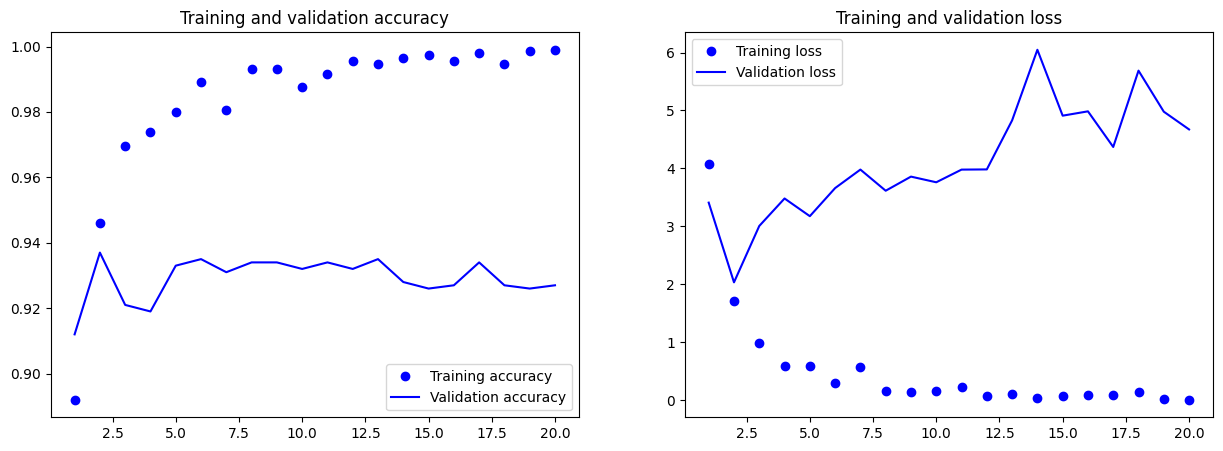

In [ ]:
check_train_val_plot(history)

# 데이터 증식을 사용한 특성 추출

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

In [ ]:
conv_base.trainable=True
print(len(conv_base.trainable_weights)) # 동결 전

26


In [ ]:
conv_base.trainable=False
print(len(conv_base.trainable_weights)) # 동결 후

0


- 데이터 증식
- 동결된 합성곱 기반층
- 밀집분류기

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# 입력층
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x) # 입력값의 스케일 조정

# 은닉층 = 합성곱 층 연결 (vgg16)
x = conv_base(x)

# 출력층
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 10s 161ms/step - loss: 2.2738 - accuracy: 0.9755 - val_loss: 3.3811 - val_accuracy: 0.9790
Epoch 2/20
63/63 [==============================] - 10s 156ms/step - loss: 2.0446 - accuracy: 0.9795 - val_loss: 3.6149 - val_accuracy: 0.9740
Epoch 3/20
63/63 [==============================] - 11s 174ms/step - loss: 2.1390 - accuracy: 0.9760 - val_loss: 6.2099 - val_accuracy: 0.9660
Epoch 4/20
63/63 [==============================] - 11s 169ms/step - loss: 1.9362 - accuracy: 0.9810 - val_loss: 3.0116 - val_accuracy: 0.9840
Epoch 5/20
63/63 [==============================] - 10s 154ms/step - loss: 2.4146 - accuracy: 0.9780 - val_loss: 3.3110 - val_accuracy: 0.9770
Epoch 6/20
63/63 [==============================] - 10s 148ms/step - loss: 0.8899 - accuracy: 0.9840 - val_loss: 4.2162 - val_accuracy: 0.9720
Epoch 7/20
63/63 [==============================] - 10s 156ms/step - loss: 1.6264 - accuracy: 0.9800 - val_loss: 2.4756 - val_accuracy: 0.9800

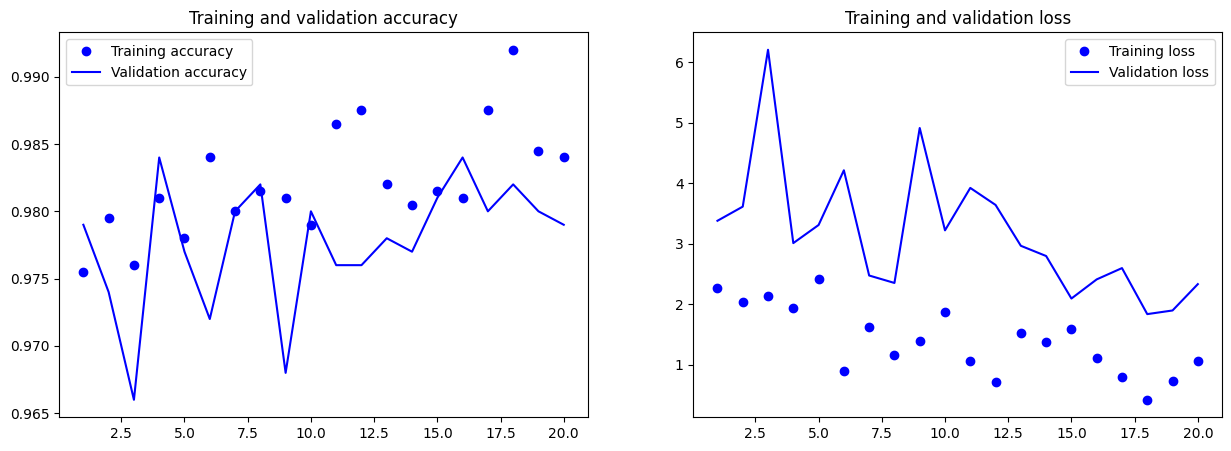

In [ ]:
check_train_val_plot(history)

## 평가

In [ ]:
test_model = keras.models.load_model(
    'feature_extraction_with_data_augmentation.keras'
)

test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 6s 93ms/step - loss: 3.0735 - accuracy: 0.9735
테스트 정확도: 0.974


## 미세 조정하기

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

- 마지막 3개의 합성곱 층 미세조정(block4_pool까지 동결이고 block5_conv1부터 block5_pool까지는 미세조정)

In [ ]:
conv_base.trainable = True # 동결 전
for layer in conv_base.layers[:-4]:
  layer.trainable = False # 동결 처음부터~ block4_pool 동결

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), # 기존의 rmsprop보다 학습률을 낮춰 진행
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 14s 179ms/step - loss: 0.6028 - accuracy: 0.9880 - val_loss: 2.3176 - val_accuracy: 0.9770
Epoch 2/30
63/63 [==============================] - 11s 176ms/step - loss: 0.7271 - accuracy: 0.9880 - val_loss: 2.3562 - val_accuracy: 0.9770
Epoch 3/30
63/63 [==============================] - 11s 174ms/step - loss: 0.3802 - accuracy: 0.9890 - val_loss: 2.2253 - val_accuracy: 0.9770
Epoch 4/30
63/63 [==============================] - 13s 209ms/step - loss: 0.5355 - accuracy: 0.9880 - val_loss: 1.9769 - val_accuracy: 0.9760
Epoch 5/30
63/63 [==============================] - 12s 185ms/step - loss: 0.3755 - accuracy: 0.9910 - val_loss: 1.7056 - val_accuracy: 0.9820
Epoch 6/30
63/63 [==============================] - 11s 166ms/step - loss: 0.2312 - accuracy: 0.9940 - val_loss: 2.0122 - val_accuracy: 0.9830
Epoch 7/30
63/63 [==============================] - 11s 169ms/step - loss: 0.5610 - accuracy: 0.9880 - val_loss: 2.0307 - val_accuracy: 0.9820

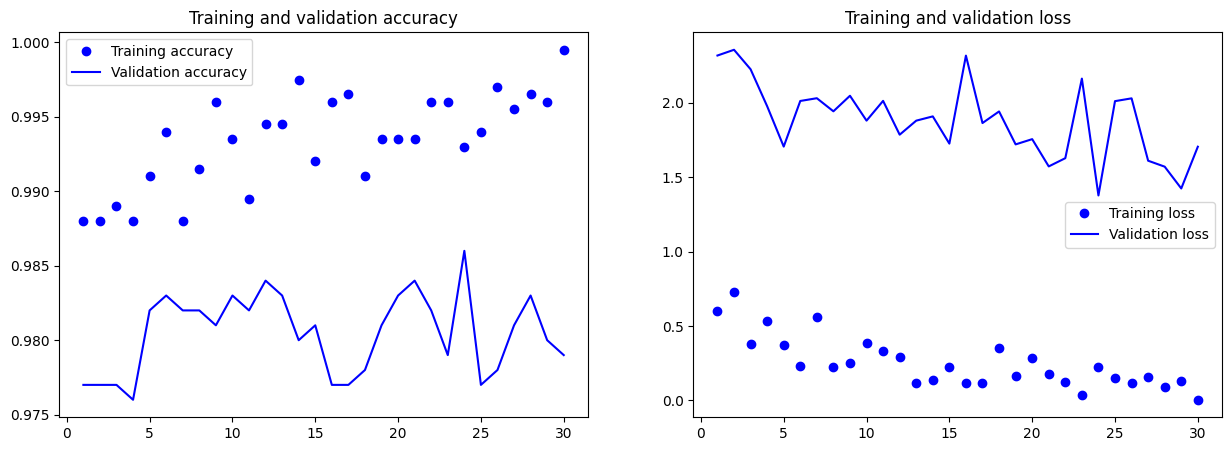

In [ ]:
check_train_val_plot(history)